In [3]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import json, codecs
import pickle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
%matplotlib notebook

Предсказывать матрицу L на L контактов в белке
Там где расстояние больше 8 А будет 0, меньше - 1
В теории будет составлены матрицы бля белков с более точной дискретизацие контактов, поделённоые на большее кол-во классов
****
Попробовать редуцировать L до констатного значения, для того, чтобы сделать L одинаковым для всех белков.
Выбрать небольшой промежуток 
Предсказывать 5 элементов для каждой аминокислоты(надо попробовать)

Stochastic gradient descent is an optimization algorithm that estimates the error gradient for the current state of the model using examples from the training dataset, then updates the weights of the model using the back-propagation of errors algorithm, referred to as simply backpropagation.

## Data-preparation

### Файл с преобразованной выборкой, состоящей из 8747 белков, каждый длиной L и 56 признаков
Файл, сформированный заранее, состоящий из признаков для обучения. В качестве признаков используются аторичная структура(3), PSSM(20), FASTA-кодировка(20), растворимость(1), 8 различных типов АК по радикалу(8), 4 различных типа АК по полярности(4)

In [4]:
pkl_file = open('data.pkl', 'rb')
data1 = pickle.load(pkl_file)
pkl_file.close()

In [5]:
#with open('data.pickle', 'wb') as f:
#     pickle.dump(data1, f)

In [6]:
#class NumpyEncoder(json.JSONEncoder):
#    def default(self, obj):
#        if isinstance(obj, np.ndarray):
#            return obj.tolist()
#        return json.JSONEncoder.default(self, obj)

In [7]:
#import json

#my_json_string = json.dumps(data1, cls=NumpyEncoder)

### Файл с матрицами попарных расстояний для каждого белка из списка хороших белков
Для всех белков из списка "хороших" белков были посчитаны опрные матрицы размерность 5 x L, которые и будут предсказываться

In [8]:
import json
with open("D:\Загрузки\supporting_matrix\data.json", "r") as read_file:
    data = json.load(read_file)

In [9]:
coords1 = pd.DataFrame()
for i in range(len(data['data'])):
    coords = pd.DataFrame({'pdb': [data['data'][i][0]], 'matrix_coord':[data['data'][i][1]]})
    coords1 =  pd.concat([coords1, coords], ignore_index=True)

In [10]:
god_prot = pd.read_csv('good_prot.csv')

Была незначительная ошибка при формировании выборки, связанная с тем, что некоторые белки повторялись, в связи с чем эти повторения необходимо удалить

In [11]:
s=0
listtodrop = []
coo = pd.DataFrame()
for pdb in god_prot.pdb_name:
    if pdb in coords1.pdb.tolist():
        coo = pd.concat([coo, coords1.loc[coords1['pdb'] == pdb]], ignore_index=True)
    else:
        listtodrop.append(pdb)

In [12]:
#coo.head(5)

In [13]:
target_basic = coo.matrix_coord.values

In [14]:
listtodrop

['5ZBT',
 '5ZDS',
 '5ZEW',
 '6CKD',
 '6E0K',
 '6FZK',
 '6G5R',
 '6HZ2',
 '6I3R',
 '6I5A',
 '6ITH',
 '6IW3',
 '6MNT',
 '6MPO',
 '6NZS',
 '6QAX',
 '6QB0',
 '6QB1']

In [15]:
target = coo.matrix_coord.values

In [16]:
data_features = pd.read_csv('pdb_and_features.csv')

In [17]:
indextodrop = []
for pdb in listtodrop:
    indextodrop.append(data_features.index[data_features.pdb_name == pdb].tolist())
    data_features = data_features[data_features.pdb_name != pdb]

In [18]:
for i in range(len(indextodrop)):
    del data1[indextodrop[i][0]]

In [19]:
data_features = data_features.reset_index(drop=True)

In [20]:
#short_pdb = []
#for i in range(len(data_features)):
    #if len(data_features.iloc[i].FASTA)<=200:
        #print(data_features.iloc[i].pdb_name)
        #short_pdb.append(data_features.iloc[i].pdb_name)

In [21]:
#len(short_pdb)

Проверяем, всё ли теперь верно и совпадают ли размерности списков матриц для обучения и список опорных матриц  

In [22]:
len(target)

8747

In [23]:
len(data1)

8747

In [25]:
"""
for i in range(len(data1)):
    if np.shape(data1[i])[0] > np.shape(target[i])[0]:
        ff = np.zeros((np.shape(data1[i])[0]-np.shape(target[i])[0], 5))
        target[i] = np.concatenate((target[i], ff), axis=0)
    elif np.shape(data1[i])[0] < np.shape(target[i])[0]:
        target[i] = target[i][:np.shape(data1[i])[0]]
"""

'\nfor i in range(len(data1)):\n    if np.shape(data1[i])[0] > np.shape(target[i])[0]:\n        ff = np.zeros((np.shape(data1[i])[0]-np.shape(target[i])[0], 5))\n        target[i] = np.concatenate((target[i], ff), axis=0)\n    elif np.shape(data1[i])[0] < np.shape(target[i])[0]:\n        target[i] = target[i][:np.shape(data1[i])[0]]\n'

In [26]:
s = 0
target_fix = []
for i in range(len(data1)):
    mm1 = np.shape(data1[i])[0]
    if np.shape(data1[i])[0] > np.shape(target[i])[0]:
        ff = np.median(target[i], axis = 0) + np.zeros((mm1-np.shape(target[i])[0], 1))
        target_fix.append(np.concatenate((target[i], ff), axis=0))
    else:
        target_fix.append(target[i][:mm1])   
        #print(i)
        #print(np.shape(data1[i])[0], np.shape(target[i])[0])
        #s+=1 
#print(s)

In [27]:
data_oned = []
target_oned = []
for i in range(len(data1)):
    if np.shape(data1[i])[0] <= 200 and np.shape(data1[i])[0]>=15: 
        data_oned.append(data1[i])
        target_oned.append(target_fix[i])
        #s+=1 
#print(s)

In [127]:
data_oned_fin = []
target_oned_fin = []
for i in range(int(len(data1)/2)):
    for j in range(len(data1[i])):
        if (np.array(target_fix[i][j])<30).all() and (np.array(target_fix[i][j])>-30).all():
            data_oned_fin.append(data1[i][j])
            target_oned_fin.append(target_fix[i] [j])

In [128]:
target_oned_fin = np.array(target_oned_fin)


In [129]:
data_oned_fin = np.array(data_oned_fin)

In [130]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor

In [137]:
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10,
                                       max_features=16,     # Out of 20000
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=4, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=5),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=5))
}

In [132]:
len(data_oned_fin)

444937

In [33]:
len(data_oned_fin)

564642

<IPython.core.display.Javascript object>


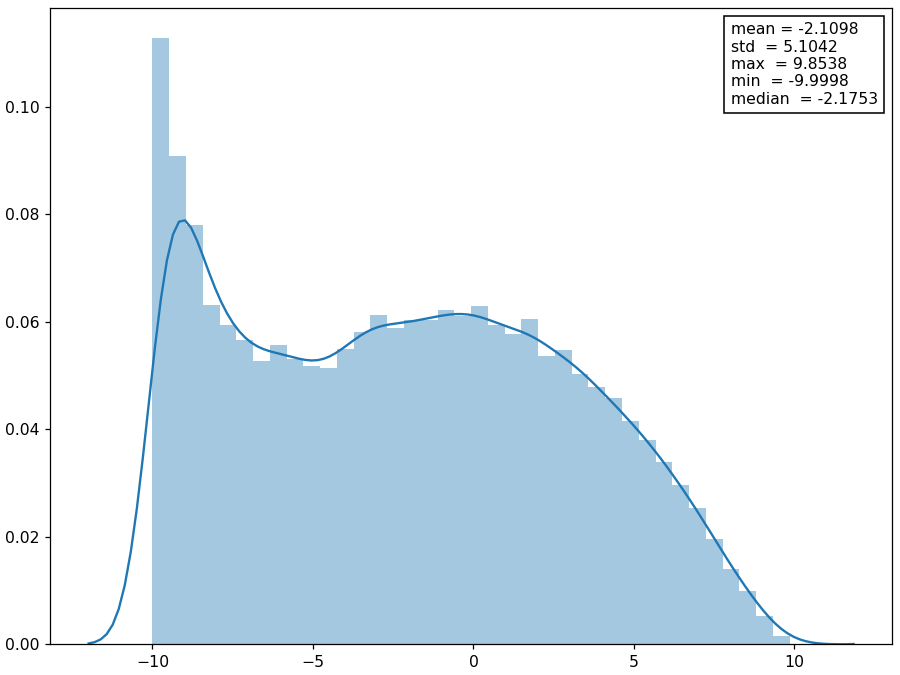

In [126]:
lab_gr = np.array([x for sublist in target_oned_fin for x in sublist])
fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
anchored_text = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (lab_gr.mean(), lab_gr.std(), lab_gr.max(), 
                                    lab_gr.min(), np.median(lab_gr)), loc='upper right')
ax.add_artist(anchored_text)
ax = sns.distplot(lab_gr)

In [121]:
def show_image(y_test_predict,name,y_mse, r2):
  ## scattor plot
    plt.figure(figsize=(8,6))
    plt.scatter(y_test_predict[name],y_test,cmap='plasma')
    plt.title(name)
    plt.show()
    lab_gr1 = np.array([x for sublist in y_test_predict[name] for x in sublist])
    lab_gr = np.array([x for sublist in y_test for x in sublist])
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
    anchored_text = AnchoredText("mean = %.4f\n"
                                     "std  = %.4f\n"
                                     "max  = %.4f\n"
                                     "min  = %.4f\n"
                                     "median  = %.4f"
                                     % (lab_gr.mean(), lab_gr.std(), lab_gr.max(), 
                                        lab_gr.min(), np.median(lab_gr)), loc='upper right')
    anchored_text1 = AnchoredText("mean = %.4f\n"
                                     "std  = %.4f\n"
                                     "max  = %.4f\n"
                                     "min  = %.4f\n"
                                     "median  = %.4f"
                                     % (lab_gr1.mean(), lab_gr1.std(), lab_gr1.max(), 
                                        lab_gr1.min(), np.median(lab_gr1)), loc='upper left')
    ax.add_artist(anchored_text)
    ax.add_artist(anchored_text1)
    ax = sns.distplot(lab_gr)
    ax = sns.distplot(lab_gr1)
    print('RMSE for ',name,' is ',y_mse[name])
    print('R^2 score for ',name,' is ',r2[name])

In [122]:
from sklearn.metrics import mean_squared_error

In [123]:
#data_oned_fin = data_oned_fin[::, np.r_[0:24, -20:0]]

In [138]:
X_train, X_test, y_train, y_test = train_test_split(data_oned_fin[:1000], target_oned_fin[:1000], test_size=0.3, random_state=12)

<IPython.core.display.Javascript object>


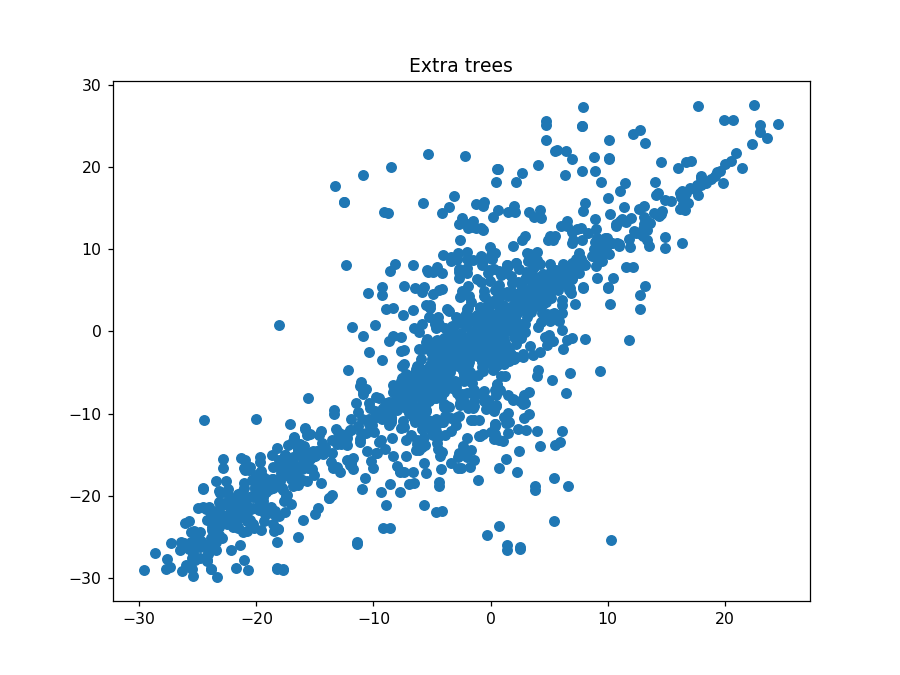

<IPython.core.display.Javascript object>


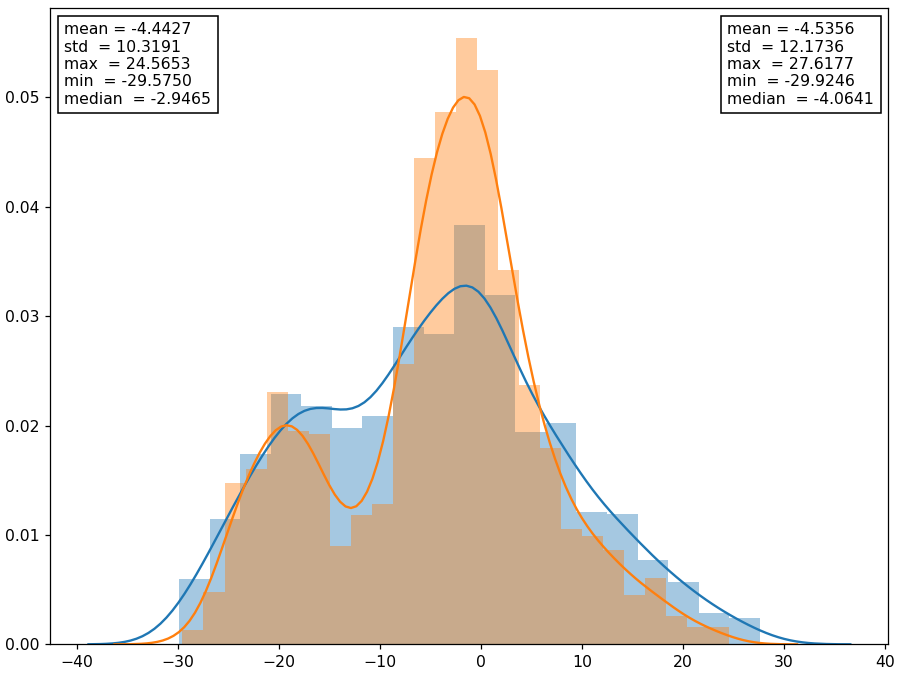

RMSE for  Extra trees  is  42.63466780117648
R^2 score for  Extra trees  is  0.5196339899846601


D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


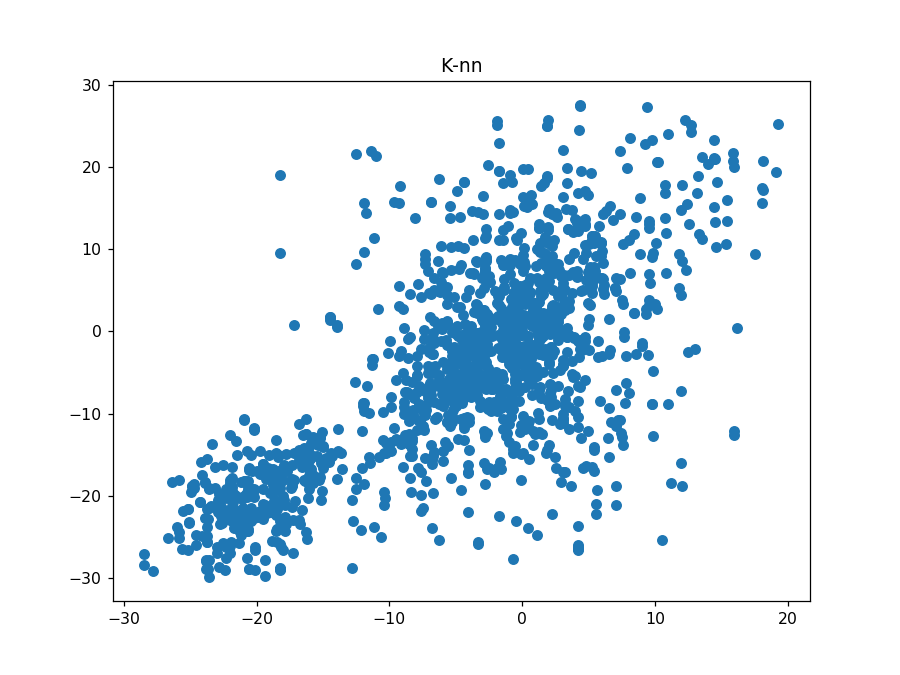

<IPython.core.display.Javascript object>


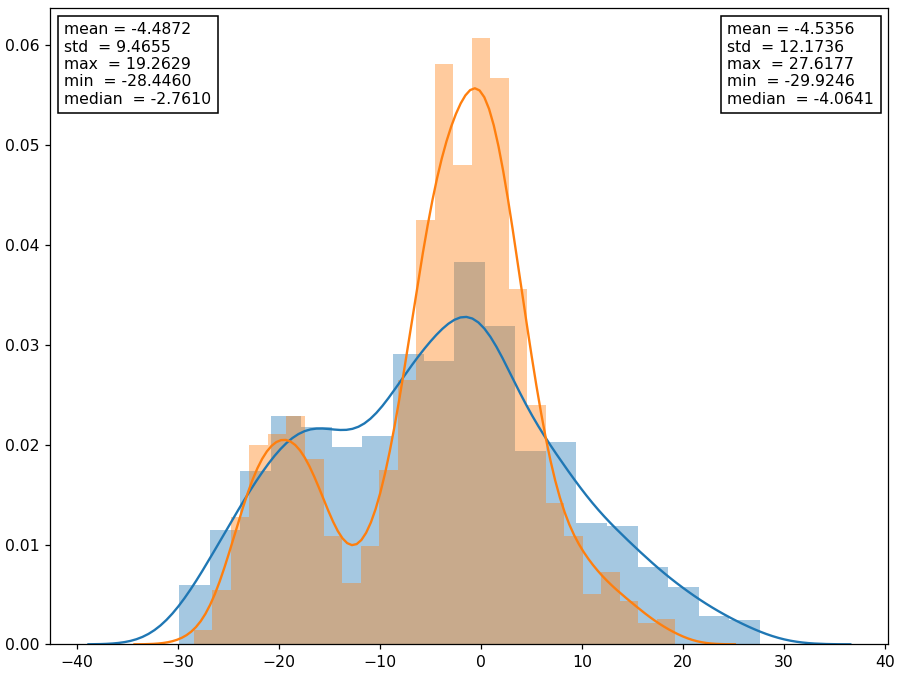

RMSE for  K-nn  is  78.52858368871134
R^2 score for  K-nn  is  0.11938461651564022


D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


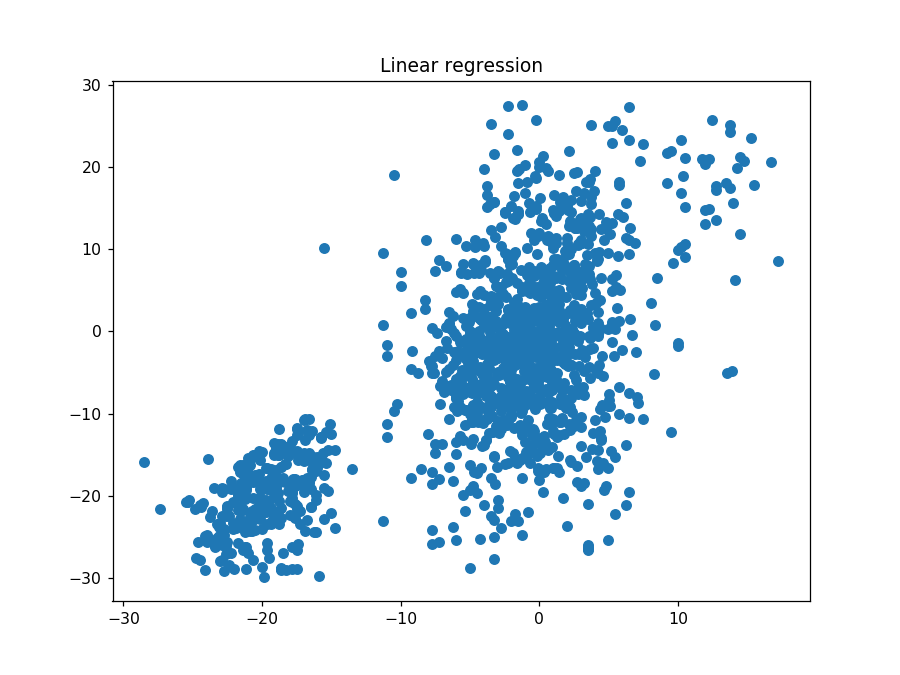

<IPython.core.display.Javascript object>


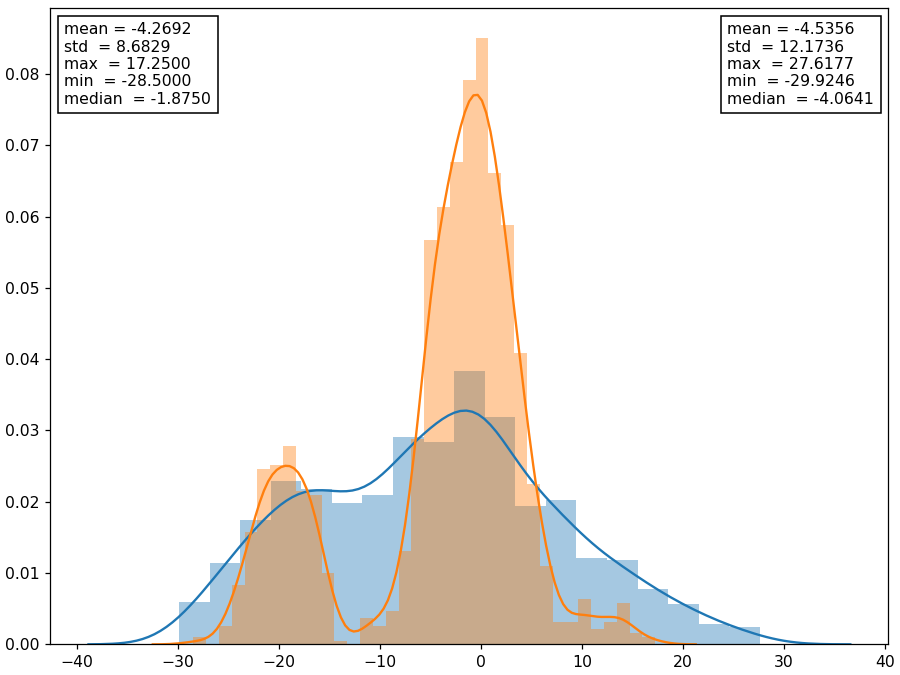

D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE for  Linear regression  is  78.02201762957162
R^2 score for  Linear regression  is  0.10344942733526422


<IPython.core.display.Javascript object>


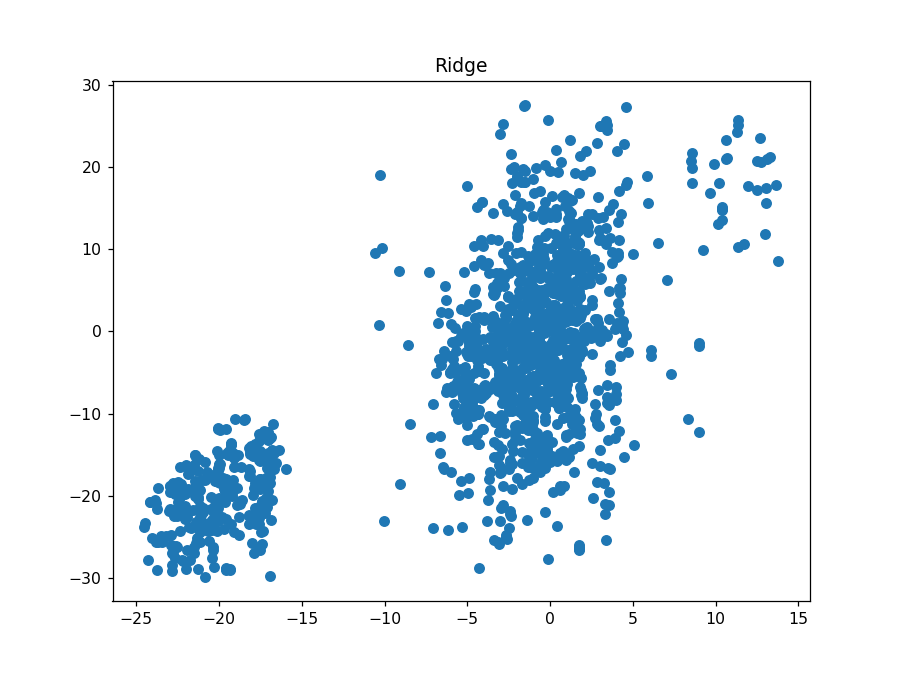

<IPython.core.display.Javascript object>


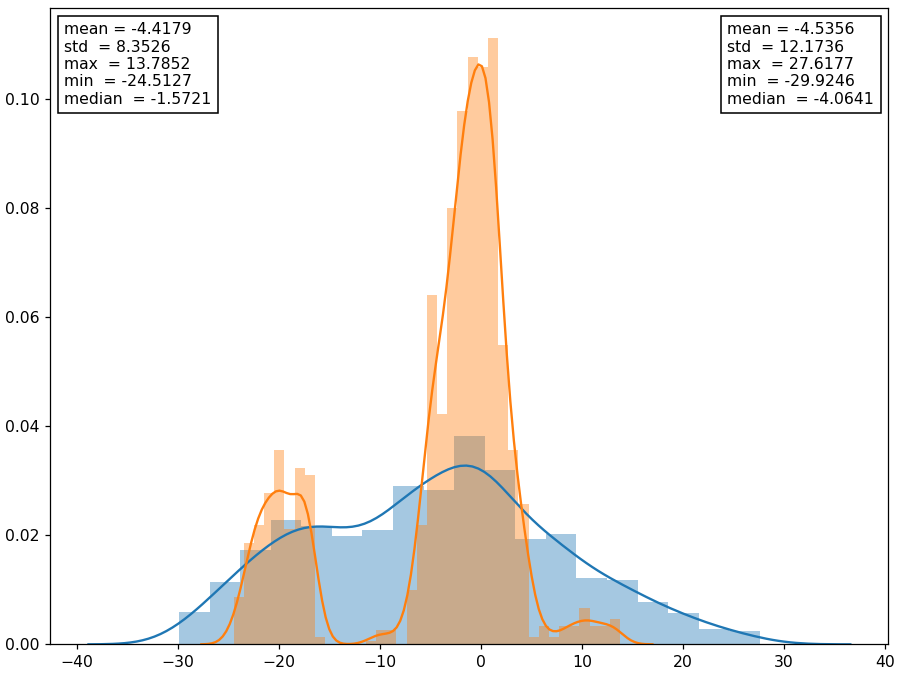

D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE for  Ridge  is  77.12491300598128
R^2 score for  Ridge  is  0.12375079064940094


<IPython.core.display.Javascript object>


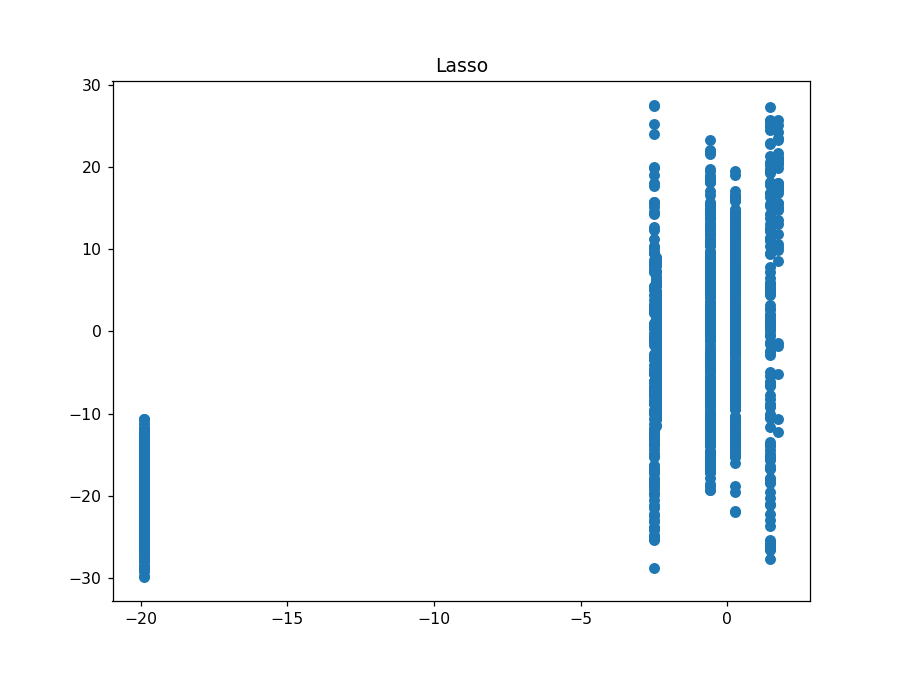

<IPython.core.display.Javascript object>


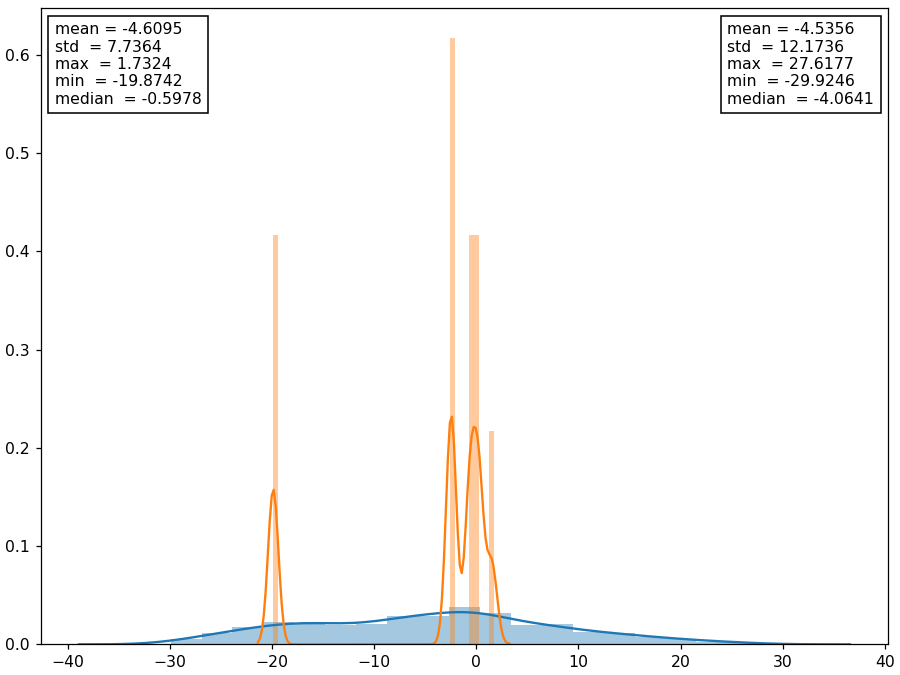

D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE for  Lasso  is  84.84545684965178
R^2 score for  Lasso  is  0.009486462975503662


<IPython.core.display.Javascript object>


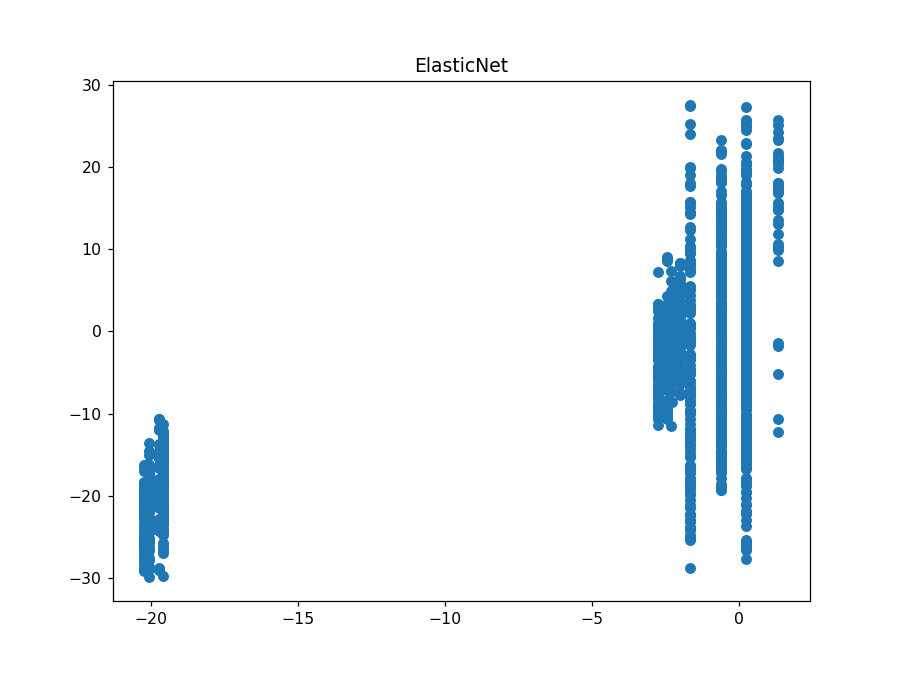

<IPython.core.display.Javascript object>


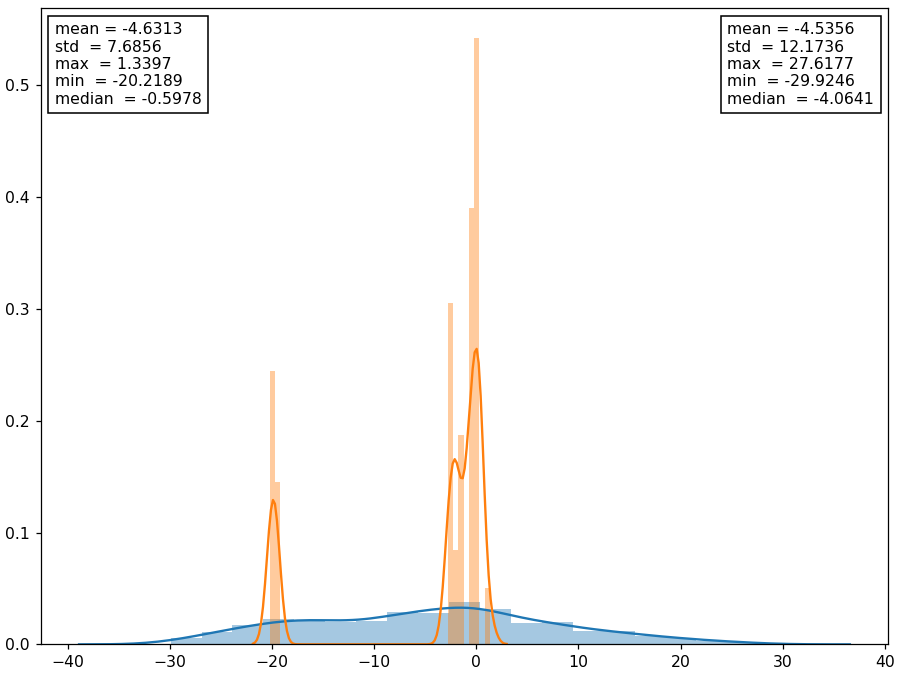

RMSE for  ElasticNet  is  84.86537350182886
R^2 score for  ElasticNet  is  0.027312338995508


D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Programms\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<IPython.core.display.Javascript object>


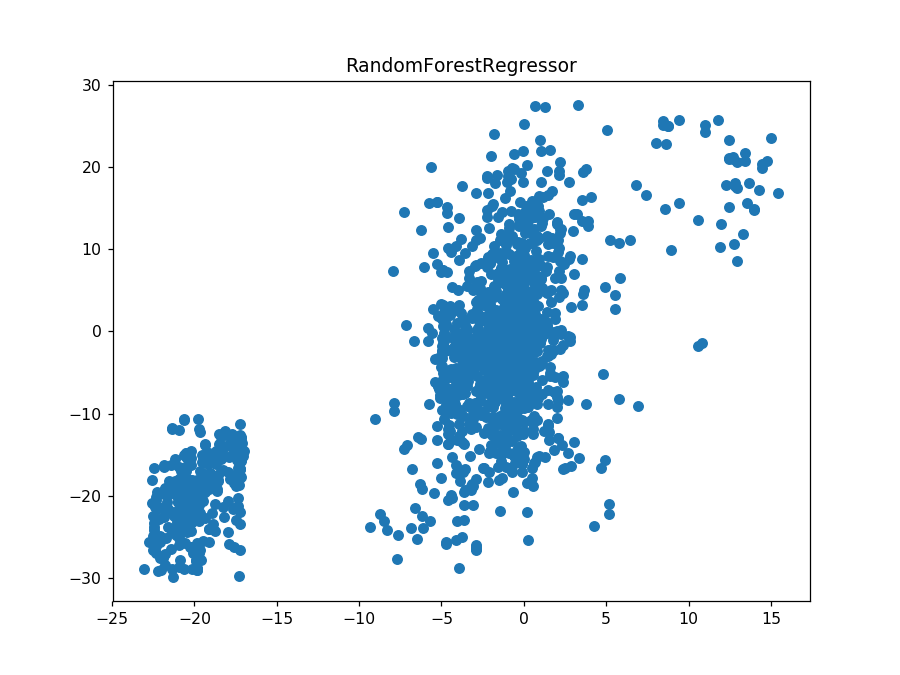

<IPython.core.display.Javascript object>


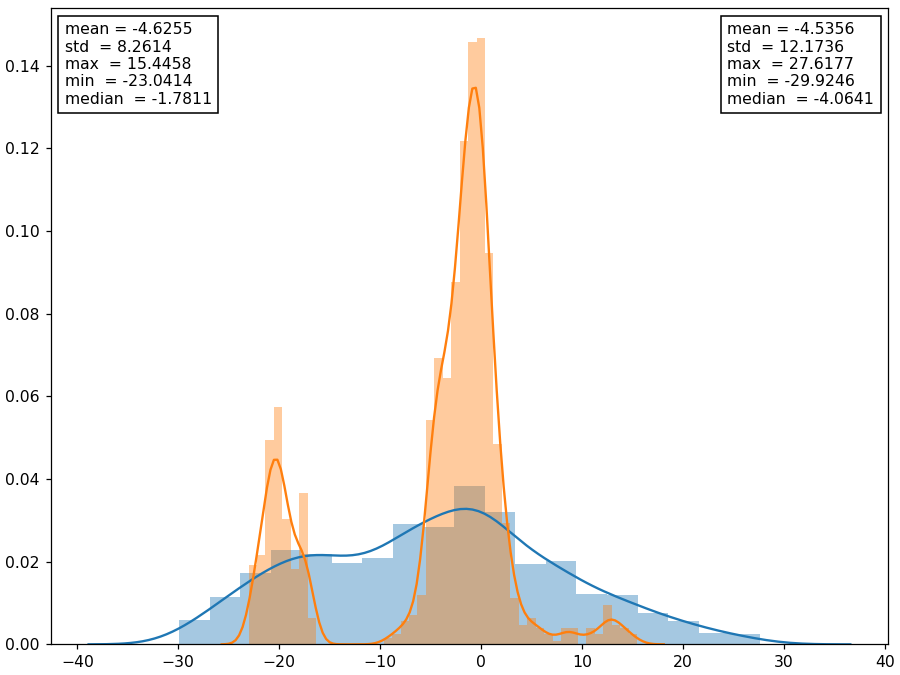

RMSE for  RandomForestRegressor  is  71.70062219122408
R^2 score for  RandomForestRegressor  is  0.14482518162729957


D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


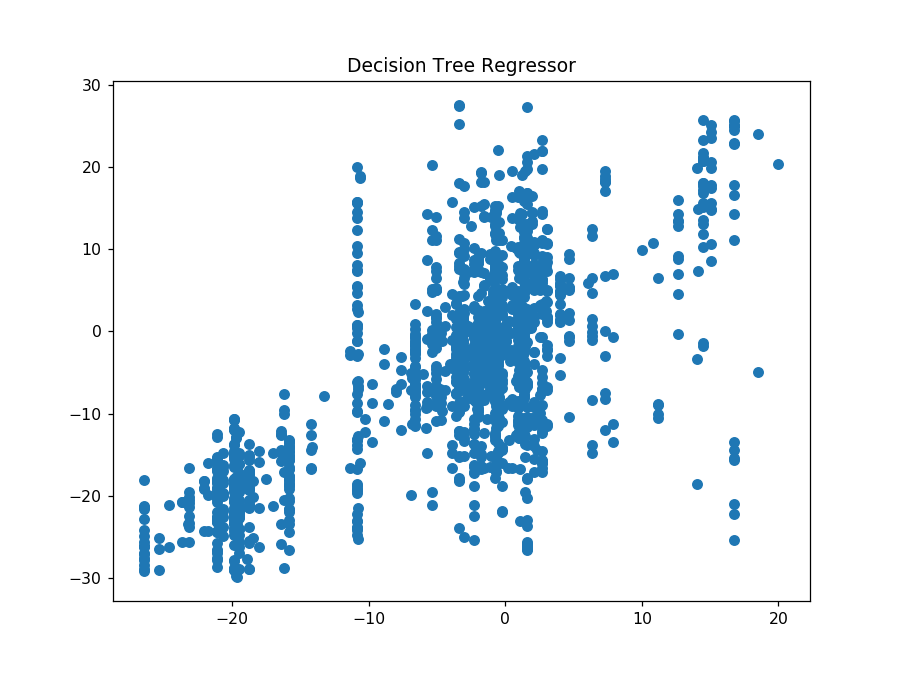

<IPython.core.display.Javascript object>


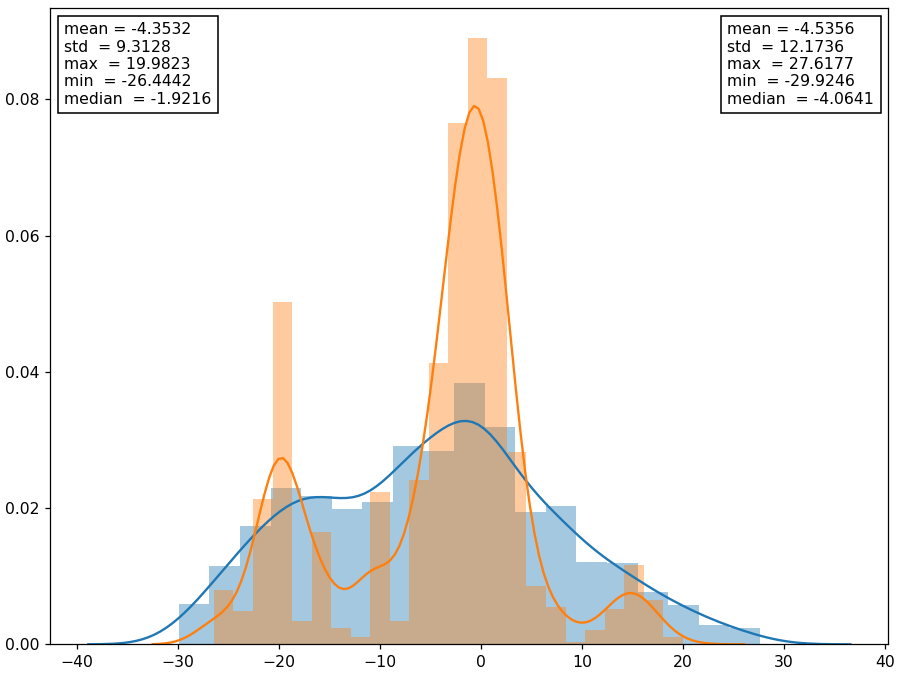

RMSE for  Decision Tree Regressor  is  78.7973562262996
R^2 score for  Decision Tree Regressor  is  0.09970214227982506


D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


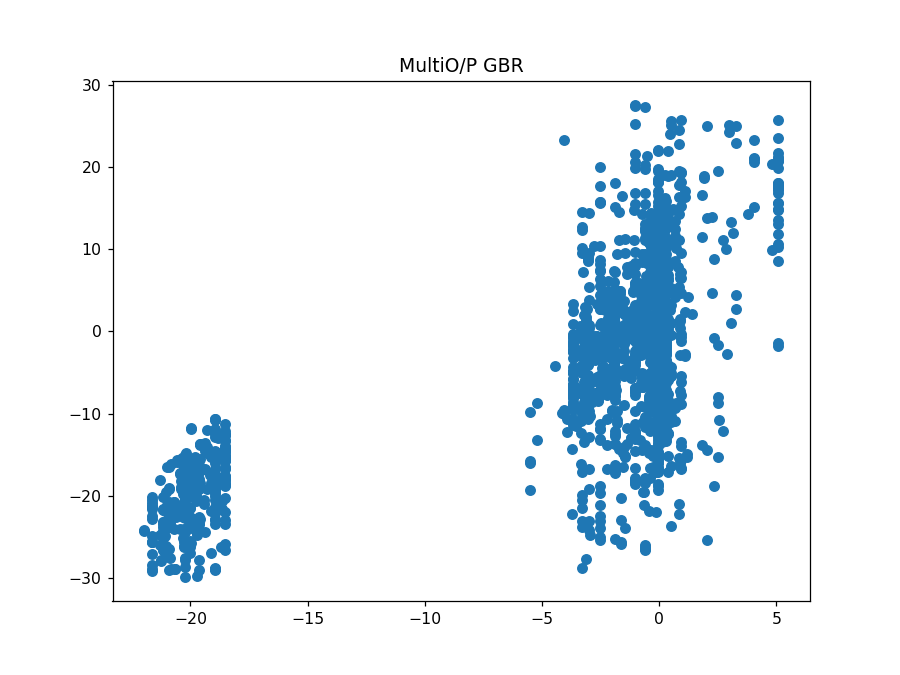

<IPython.core.display.Javascript object>


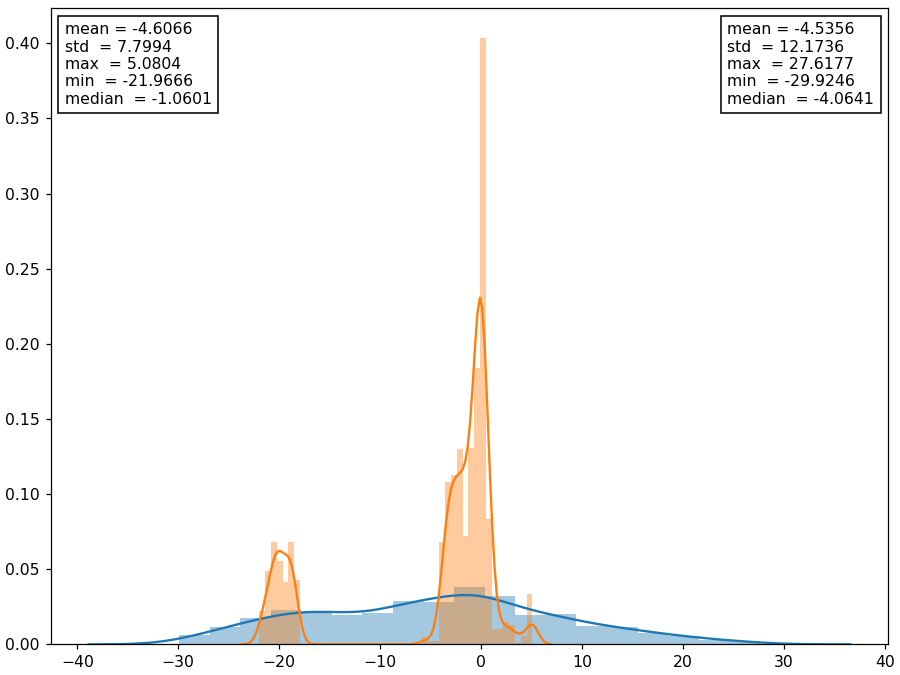

D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE for  MultiO/P GBR  is  79.15598160171739
R^2 score for  MultiO/P GBR  is  0.10364940907361553


<IPython.core.display.Javascript object>


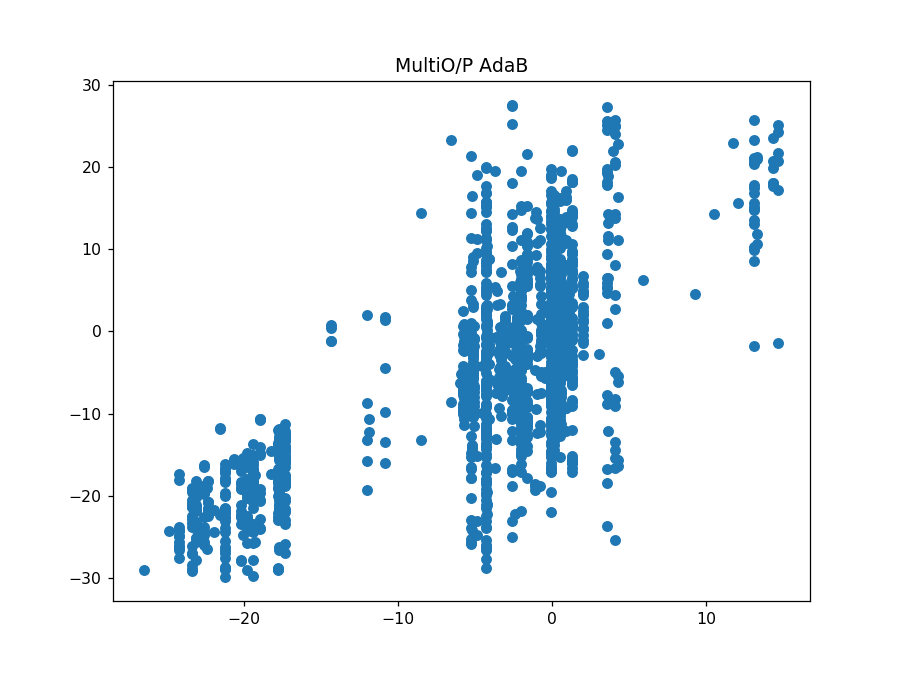

D:\Programms\Anaconda\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


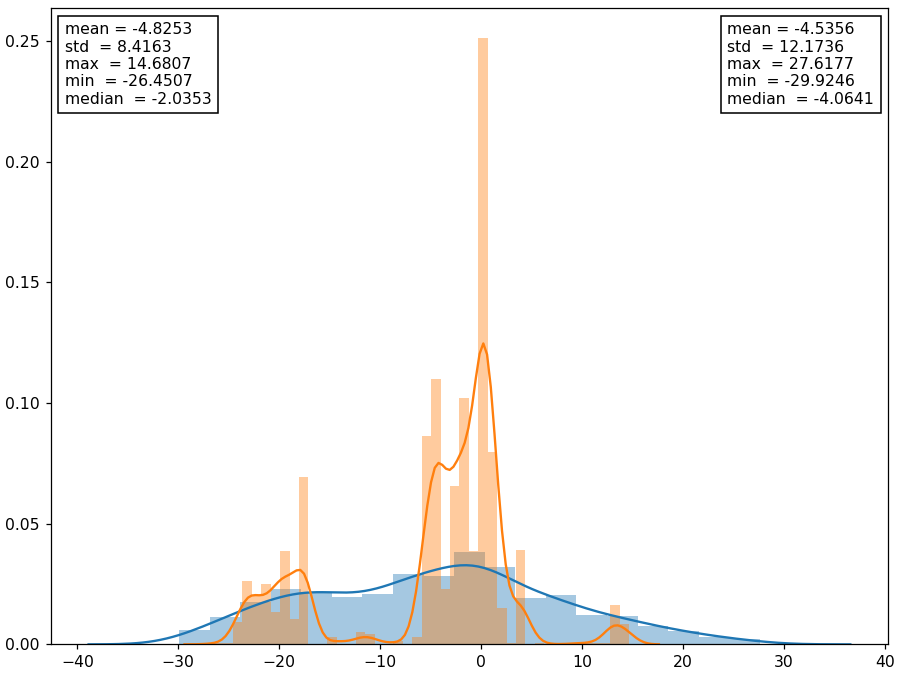

D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE for  MultiO/P AdaB  is  73.79592914859262
R^2 score for  MultiO/P AdaB  is  0.1468112973114975


In [139]:
# 9.1 Create an empty dictionary to collect prediction values
y_test_predict = dict()
y_mse = dict()
r2 = dict()

for name, estimator in ESTIMATORS.items():     
    estimator.fit(X_train, y_train)                    # fit() with instantiated object
    y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
    y_mse[name] = mean_squared_error(y_test, estimator.predict(X_test))
    r2[name] = r2_score(y_test, estimator.predict(X_test))
    show_image(y_test_predict,name, y_mse, r2)

In [297]:
print(data_features.iloc[0])
print('---')
print(coo.iloc[0])
print('---')
print('Длина цепочки fasta',len(data_features.iloc[0].FASTA))
print('Длина белка из матрицы расстояний',np.shape(coo.iloc[0].matrix_coord)[0])
print('Длина белка из выборки для обучения',np.shape(data1[0])[0])

Unnamed: 0                                                    0
pdb_name                                                   132L
FASTA         KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...
Radical       5010573000075560034150120046070051324142402454...
Polarity      1000102000001130021110110010000010211011101111...
SS            CECCHHHHHHHHHHCCCCCECCECHHHHHHHHHHHHCCECCCEEEC...
ACC           ee-eeee--e--ee-e-eeeee-e--------ee--e-e-e-eeee...
PSSM          [[0.0, 0.14, 0.0, 0.0, 0.0, 0.02, 0.03, 0.0, 0...
Name: 0, dtype: object
---
pdb                                                          132L
matrix_coord    [[-20.7465629578, -2.3104770184, 19.6957874298...
Name: 0, dtype: object
---
Длина цепочки fasta 129
Длина белка из матрицы расстояний 129
Длина белка из выборки для обучения 129


In [298]:
#data.head(5)

In [299]:
target_lin = []
for i in range(len(data_features)):
    target_lin.append(len(data_features.FASTA[i]))

In [300]:
target_lin = np.array(target_lin)

In [301]:
"""
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
anchored_text = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (target_lin.mean(), target_lin.std(), target_lin.max(), 
                                    target_lin.min(), np.median(target_lin)), loc='upper right')
ax.add_artist(anchored_text)
ax = sns.distplot(target_lin)
"""

'\nfig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)\nanchored_text = AnchoredText("mean = %.4f\n"\n                                 "std  = %.4f\n"\n                                 "max  = %.4f\n"\n                                 "min  = %.4f\n"\n                                 "median  = %.4f"\n                                 % (target_lin.mean(), target_lin.std(), target_lin.max(), \n                                    target_lin.min(), np.median(target_lin)), loc=\'upper right\')\nax.add_artist(anchored_text)\nax = sns.distplot(target_lin)\n'

In [302]:
low_border = 5
high_border = 20

In [303]:
target_lin_ = target_lin[(target_lin<=high_border) & (target_lin>=low_border)]

In [304]:
len(target_lin_)

279

In [305]:
"""
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
anchored_text = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (target_lin_.mean(), target_lin_.std(), target_lin_.max(), 
                                    target_lin_.min(), np.median(target_lin_)), loc='upper right')
ax.add_artist(anchored_text)
ax = sns.distplot(target_lin_)
"""

'\nfig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)\nanchored_text = AnchoredText("mean = %.4f\n"\n                                 "std  = %.4f\n"\n                                 "max  = %.4f\n"\n                                 "min  = %.4f\n"\n                                 "median  = %.4f"\n                                 % (target_lin_.mean(), target_lin_.std(), target_lin_.max(), \n                                    target_lin_.min(), np.median(target_lin_)), loc=\'upper right\')\nax.add_artist(anchored_text)\nax = sns.distplot(target_lin_)\n'

In [306]:
"""
data_acids = []
for i in range(len(data1)):
    for j in range(len(data1[i])):
    #print(i)
        data_acids.append(data1[i][j])
"""

'\ndata_acids = []\nfor i in range(len(data1)):\n    for j in range(len(data1[i])):\n    #print(i)\n        data_acids.append(data1[i][j])\n'

In [307]:
"""
data_acids = np.array(data_acids)
"""

'\ndata_acids = np.array(data_acids)\n'

In [308]:
"""
corrmat = np.corrcoef(data_acids.T)
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap="YlGnBu")
"""

'\ncorrmat = np.corrcoef(data_acids.T)\nplt.subplots(figsize=(12,9))\nsns.heatmap(corrmat, vmax=0.9, square=True, cmap="YlGnBu")\n'

In [309]:
#data_acids.shape

In [310]:
"""
target_acids = []
for i in range(len(target)//2):
    for j in range(len(target[i])):
        if np.shape(target[i])[0] > np.shape(data1[i])[0]:
            f = np.zeros((np.shape(target[i])[0]-np.shape(data1[i])[0], 5))
            target[i] = np.concatenate((target[i], f), axis=0)
        else:
            target[i] = target[i][:np.shape(data1[i])[0]]
        target_acids.append(target[i][j])
        """

'\ntarget_acids = []\nfor i in range(len(target)//2):\n    for j in range(len(target[i])):\n        if np.shape(target[i])[0] > np.shape(data1[i])[0]:\n            f = np.zeros((np.shape(target[i])[0]-np.shape(data1[i])[0], 5))\n            target[i] = np.concatenate((target[i], f), axis=0)\n        else:\n            target[i] = target[i][:np.shape(data1[i])[0]]\n        target_acids.append(target[i][j])\n        '

In [311]:
#np.shape(target_acids)

In [312]:
#np.array(target_acids).shape

In [313]:
"""
data.iloc[183]
len(data.iloc[183].FASTA)
len(data.iloc[183].ACC)
np.shape(coo.iloc[183].matrix_coord)
np.shape(data1[183])
"""

'\ndata.iloc[183]\nlen(data.iloc[183].FASTA)\nlen(data.iloc[183].ACC)\nnp.shape(coo.iloc[183].matrix_coord)\nnp.shape(data1[183])\n'

In [314]:
len(data1)

8747

In [315]:
len(target)

8747

In [316]:
len(data_features)

8747

In [317]:
"""
s = 0
for i in range(len(data1)):
    if np.shape(data1[i])[0] != np.shape(target[i])[0]:
        print('Номер белка', i)
        print('Длина белка по базе Pdb', np.shape(data1[i])[0])
        print('Длина белка по мазе MMTF', np.shape(target[i])[0])
        s+=1 
print(s)
"""

"\ns = 0\nfor i in range(len(data1)):\n    if np.shape(data1[i])[0] != np.shape(target[i])[0]:\n        print('Номер белка', i)\n        print('Длина белка по базе Pdb', np.shape(data1[i])[0])\n        print('Длина белка по мазе MMTF', np.shape(target[i])[0])\n        s+=1 \nprint(s)\n"

In [318]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=50)

In [319]:
data_f = []
mm = high_border#max(target_lin)
for i in range(len(data1)):
    if (high_border>=np.shape(data1[i])[0]):
        f = np.median(data1[0], axis = 0) + np.zeros((mm-np.shape(data1[i])[0], 1))
        #f = np.zeros((mm-np.shape(data1[i])[0], 56))
        #data1[i] = np.concatenate((data1[i], f), axis=0)
        data_f.append(np.concatenate((data1[i], f), axis=0))
    else:
         data_f.append(data1[i][:mm])

In [320]:
#pca1 = PCA(n_components=5)

In [321]:
target.shape

(8747,)

In [322]:
target1 = []
mm1 = high_border
for i in range(len(target)):
    if (high_border>=np.shape(target[i])[0]):
        #ff = np.zeros((mm1-np.shape(target[i])[0], 5))
        ff = np.median(target[0], axis = 0) + np.zeros((mm1-np.shape(target[i])[0], 1))
        #target[i] = np.concatenate((target[i], ff), axis=0)
        target1.append(np.concatenate((target[i], ff), axis=0))
    else:
        target1.append(target[i][:mm1])
    #target1.append(target[i])

In [323]:
data_f = np.array(data_f)

In [324]:
data_f.shape

(8747, 20, 56)

In [325]:
train = data_f[(target_lin<=high_border) & (target_lin>=low_border)]

In [326]:
target1 = np.array(target1)

In [327]:
np.shape(target1)

(8747, 20, 5)

In [328]:
target_f = target1[(target_lin<=high_border) & (target_lin>=low_border)]

In [329]:
train.shape

(279, 20, 56)

In [330]:
target_f.shape

(279, 20, 5)

In [331]:
len(target_lin_)

279

In [332]:
target_f = target_f.reshape(target_f.shape[0], 5*(mm1))

In [333]:
#from  sklearn.preprocessing import OneHotEncoder, LabelEncoder, KBinsDiscretizer

In [334]:
#kbin = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
#kbin.fit(target_f)
#target_disc = kbin.transform(target_f)

In [335]:
#target_f[0]

In [336]:
#np.mean(abs(target_f-kbin.inverse_transform(target_disc)))

In [337]:
target_f.shape

(279, 100)

In [338]:
#for i in range(target_f.shape[0]):
#    for j in range(target_f.shape[1]):
#        if target_f[i][j]>30 or target_f[i][j]<-30:
#            print(i)

In [339]:
#target_f = (np.round(target_f, decimals = 3)*1000).astype(int)

In [340]:
#target_f = np.around(target_f, decimals=4)

In [341]:
#target = preprocessing.scale(target)

In [342]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2 # L2-regularisation
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
# ...
l2_lambda = 0.0001

In [343]:
train = train.reshape(-1, mm, 56, 1)

In [344]:
train = train[::, ::, np.r_[0:24, -20:0], ::]

In [345]:
train.shape

(279, 20, 44, 1)

In [346]:
train_X,train_val_test,train_label,target_val_test = train_test_split(train, target_f, test_size=0.2, random_state=13)

In [347]:
test_X,valid_X,test_label,valid_label = train_test_split(train_val_test, target_val_test, test_size=0.5, random_state=13)

In [348]:
batch_size = 16
epochs = 50

In [349]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [350]:
model = Sequential()
#1 слой
model.add(Conv2D(20, kernel_size=(mm, 10),activation='linear',padding='same', W_regularizer=l2(l2_lambda), input_shape=(mm, 44, 1)))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                beta_initializer='zeros', gamma_initializer='ones', 
#                                moving_mean_initializer='zeros', moving_variance_initializer='ones', 
#                                beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(MaxPooling2D((2, 2),padding='same'))# уменьшаем размерность до 2 на 2
model.add(Dropout(0.5))
#2 слой
model.add(Conv2D(20, (mm, 10), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.1))
#3 слой3
model.add(Conv2D(20, (mm, 10), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.1))
#4 слой
#model.add(Conv2D(20, (mm, 10), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
#model.add(LeakyReLU(alpha=0.1))                  
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Dropout(0.1))
#5 слой
#model.add(Conv2D(20, (mm, 10), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
#model.add(LeakyReLU(alpha=0.1))                  
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Dropout(0.1))               
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(155, activation='linear', W_regularizer=l2(l2_lambda)))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.1))
model.add(Dense((5*(mm1)), activation='linear'))

D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, kernel_size=(20, 10), activation="linear", padding="same", input_shape=(20, 44, 1..., kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (20, 10), activation="linear", padding="same", kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (20, 10), activation="linear", padding="same", kernel_regularizer=<keras.reg...)`
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(155, activation="linear", kernel_regularizer=<keras.reg...)`


In [351]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 44, 20)        4020      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 20, 44, 20)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 22, 20)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 22, 20)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 22, 20)        80020     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 10, 22, 20)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 11, 20)         0         
__________

1) Батч-нормализация не нужна
2) Чем меньше данныых тем меньше слоёв лучше использовать
3) При уменьшении слоёв происходит переобучение, мб уменьшить лёрнинг рейт
4) трёх слоёв достаточно
5) батч-сайз = 16

In [352]:
#model.compile(loss="mean_squared_logarithmic_error", optimizer=keras.optimizers.Adam(),metrics=['mae', 'mse', coeff_determination])

In [353]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=0.001), metrics=['msle', 'mae', coeff_determination])

In [354]:
#optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [355]:
#model.compile(loss="mean_absolute_error", optimizer=keras.optimizers.Adam(),metrics=['msle', 'mse', coeff_determination])

In [356]:
#multi_target_forest = MultiOutputClassifier(model, n_jobs=-1)
#multi_target_forest.fit(train_X, train_label)

In [357]:
#from sklearn.multioutput import MultiOutputClassifier

In [358]:
train_dropout = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,
                          validation_data=(valid_X, valid_label))

Train on 223 samples, validate on 28 samples
Epoch 1/50
223/223 [==============================] - 2s 10ms/step - loss: 55.1492 - mean_squared_logarithmic_error: 0.5050 - mean_absolute_error: 4.8289 - coeff_determination: -0.1015 - val_loss: 43.5972 - val_mean_squared_logarithmic_error: 0.6853 - val_mean_absolute_error: 4.8360 - val_coeff_determination: 0.1152
Epoch 2/50
223/223 [==============================] - 1s 6ms/step - loss: 40.5403 - mean_squared_logarithmic_error: 0.4339 - mean_absolute_error: 4.1911 - coeff_determination: 0.2000 - val_loss: 73.0192 - val_mean_squared_logarithmic_error: 0.6887 - val_mean_absolute_error: 5.7796 - val_coeff_determination: -0.4843
Epoch 3/50
223/223 [==============================] - 1s 6ms/step - loss: 25.3835 - mean_squared_logarithmic_error: 0.4385 - mean_absolute_error: 3.3127 - coeff_determination: 0.5011 - val_loss: 21.1450 - val_mean_squared_logarithmic_error: 0.4042 - val_mean_absolute_error: 3.0540 - val_coeff_determination: 0.5705
Epoc

Epoch 27/50
223/223 [==============================] - 1s 6ms/step - loss: 10.1324 - mean_squared_logarithmic_error: 0.2817 - mean_absolute_error: 2.1158 - coeff_determination: 0.8037 - val_loss: 20.9924 - val_mean_squared_logarithmic_error: 0.4074 - val_mean_absolute_error: 2.9964 - val_coeff_determination: 0.5741
Epoch 28/50
223/223 [==============================] - 1s 6ms/step - loss: 10.2287 - mean_squared_logarithmic_error: 0.2850 - mean_absolute_error: 2.1337 - coeff_determination: 0.7997 - val_loss: 22.1050 - val_mean_squared_logarithmic_error: 0.4372 - val_mean_absolute_error: 3.1007 - val_coeff_determination: 0.5515
Epoch 29/50
223/223 [==============================] - 1s 6ms/step - loss: 10.3816 - mean_squared_logarithmic_error: 0.2841 - mean_absolute_error: 2.1555 - coeff_determination: 0.7976 - val_loss: 18.2897 - val_mean_squared_logarithmic_error: 0.3834 - val_mean_absolute_error: 2.7546 - val_coeff_determination: 0.6291
Epoch 30/50
223/223 [============================

<IPython.core.display.Javascript object>


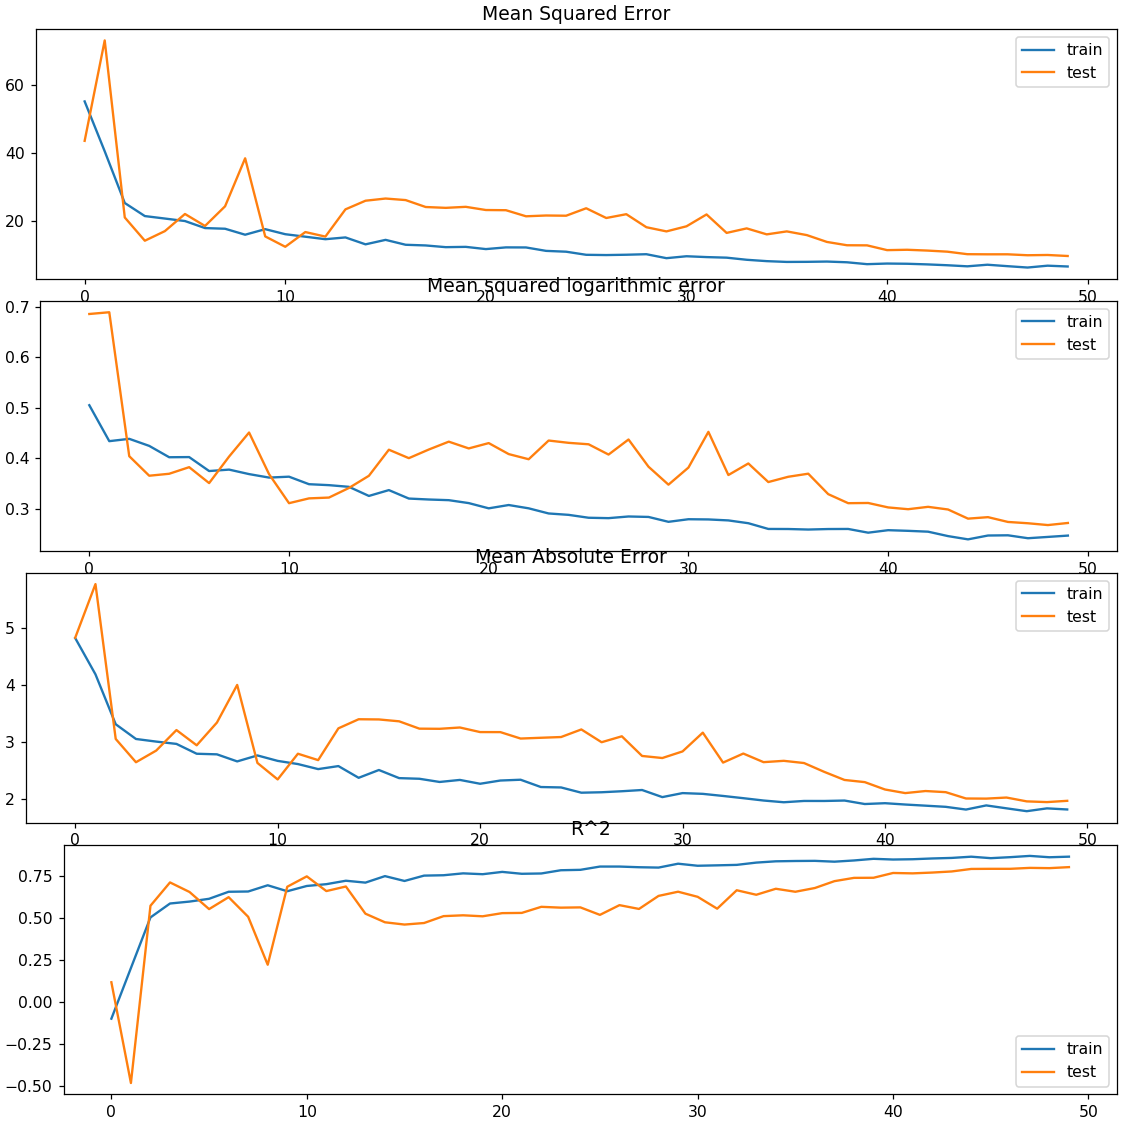

In [359]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), constrained_layout=True)
plt.subplot(411)
plt.title('Mean Squared Error')
plt.plot((train_dropout.history['loss']), label='train')
plt.plot((train_dropout.history['val_loss']), label='test')
plt.legend()
# plot mse during training
plt.subplot(412)
plt.title('Mean squared logarithmic error ')
plt.plot(train_dropout.history['mean_squared_logarithmic_error'], label='train')
plt.plot(train_dropout.history['val_mean_squared_logarithmic_error'], label='test')
plt.legend()
plt.subplot(413)
plt.title('Mean Absolute Error')
plt.plot((train_dropout.history['mean_absolute_error']), label='train')
plt.plot((train_dropout.history['val_mean_absolute_error']), label='test')
plt.legend()
plt.show()
plt.subplot(414)
plt.title('R^2')
plt.plot((train_dropout.history['coeff_determination']), label='train')
plt.plot((train_dropout.history['val_coeff_determination']), label='test')
plt.legend()
plt.show()

In [360]:
pred = model.predict(test_X)

In [361]:
from sklearn.metrics import r2_score
mme = 0
len_of_prot = []
fake_mean = []
fake_r2 = []
real_r2 = []
real_mean = []
#TT_pred = []
real_pred = []
real_test = []
for i in range(len(pred)):
        real_test_lab = []
        real_pred_lab = []
        r = np.sum(test_label[i].reshape(len(test_label[i])//5, 5), axis = 1)
        #print(r[len(r)-2])
       #print(r)
        #print(len(r))
        for j in range(len(r)-1):
            #print(len(r))
            if r[j] == r[j + 1]:
                g=r[j]
              #  print('не край')
              #  print(int(r.tolist().index(g))*5)
                real_test_lab = test_label[i].reshape(len(test_label[i])//5, 5)[:int(r.tolist().index(g))]
                real_test.append(test_label[i][:int(r.tolist().index(g))*5])
                real_pred_lab = pred[i].reshape(len(test_label[i])//5, 5)[:int(r.tolist().index(g))]
                real_pred.append(pred[i][:int(r.tolist().index(g))*5])
               # print(np.shape(real_test[i]))
               # print(np.shape(real_pred[i]))
                break
            if j == len(r)-2 and r[j] != r[j+1] :
               # print('край')
                real_test_lab = test_label[i].reshape(len(test_label[i])//5, 5)
                real_pred_lab = pred[i].reshape(len(test_label[i])//5, 5)
                real_pred.append(pred[i])
                real_test.append(test_label[i])
                #print(np.shape(real_test[i]))
                #print(np.shape(real_pred[i]))      
        len_of_prot.append(len(real_test_lab))
        fake_r2.append(r2_score(test_label[i], pred[i]))
        real_r2.append(r2_score(real_test_lab, real_pred_lab))
        real_mean.append(np.mean(abs(real_test_lab - real_pred_lab)))
        fake_mean.append(np.mean(abs(pred[i]-test_label[i])))
        #if (test_label[i].tolist().count(0) == 0):
        #    len_of_prot.append(len(test_label[i])//5)
        #    fake_mean.append(np.mean(abs(pred[i]-test_label[i])))
        #    #print(int(valid_label[i].tolist().index(0)/5))
        #    fake_r2.append(r2_score(test_label[i], pred[i]))
        #    real_pred.append(pred[i][:len(test_label[i])//5])
        #    real_valid_lab.append(test_label[i][:len(test_label[i])//5])
        #    #print(valid_label[i])
        #    #print(pred[i])
        #    #print((valid_label[i][:int(valid_label[i].tolist().index(0))].reshape(int(valid_label[i].tolist().index(0)/5),5)))
        #    trans_valid = test_label[i].reshape(len(test_label[i])//5, 5)
        #    trans_pred = pred[i].reshape(len(test_label[i])//5, 5)
        #    real_r2.append(r2_score(trans_valid, trans_pred))
        #    real_mean.append(np.mean(abs(trans_valid - trans_pred)))
        #print(np.mean(abs(pred[i]-valid_label[i])))
        #elif int(test_label[i].tolist().index(0)/5)!=0:
        #    #print(i)
        #    real_pred.append(pred[i][:int(test_label[i].tolist().index(0))])
        #    real_valid_lab.append(test_label[i][:int(test_label[i].tolist().index(0))])
        #    len_of_prot.append(int(test_label[i].tolist().index(0)/5))
        #    fake_mean.append(np.mean(abs(pred[i]-test_label[i])))
        #    #print(int(valid_label[i].tolist().index(0)/5))
        #    fake_r2.append(r2_score(test_label[i], pred[i]))
        #   # print(valid_label[i])
        #    #print(pred[i])
        #    #print((valid_label[i][:int(valid_label[i].tolist().index(0))].reshape(int(valid_label[i].tolist().index(0)/5),5)))
        #    trans_valid = test_label[i][:int(test_label[i].tolist().index(0))].reshape(int(test_label[i].tolist().index(0)/5),5)
        #    trans_pred = pred[i][:int(test_label[i].tolist().index(0))].reshape(int(test_label[i].tolist().index(0)/5), 5)
        #    real_r2.append(r2_score(trans_valid, trans_pred))
        #    real_mean.append(np.mean(abs(trans_valid - trans_pred)))
            #print(trans_valid)
            #print(trans_pred)
    #TT.append(valid_label[i][:int(valid_label[i].tolist().index(0))].reshape((valid_label[i].tolist().index(0)/5),5))
    #TT_pred.append(pred[i][:int(valid_label[i].tolist().index(0))].reshape((valid_label[i].tolist().index(0)/5), 5))

In [362]:
#fig = plt.figure(figsize=(8, 8))
#ax1 = fig.add_subplot(111)
#ax1.set_title('MAE from len of protein')
#ax1.scatter(np.linspace(1, len(test_label[real_mean == min(real_mean)][0]), len(test_label[real_mean == min(real_mean)][0])), 
#            abs(test_label[real_mean == min(real_mean)][0] -  pred[real_mean == min(real_mean)][0]), c = 'r')
#ax1.grid()

In [376]:
np.mean(abs(pred[0] - test_label[0]))

0.85729872233945

In [377]:
pred[0]

array([-9.8744564e+00, -9.4842958e+00,  3.0927088e+00,  9.2790797e-02,
       -3.8731256e-01, -5.7721686e+00, -4.9528995e+00, -1.1619424e+00,
       -2.0089412e+00, -2.4949773e-01, -5.2429986e+00, -1.8257752e-01,
       -4.2053428e+00,  5.7165474e-01, -2.9634383e-01, -4.6614804e+00,
        4.9159698e+00, -3.7171907e+00, -1.5080420e+00, -1.0736201e-02,
       -6.5674639e+00,  7.6855855e+00, -1.4495568e-01,  5.2252632e-01,
       -2.1612935e-01, -9.7503033e+00,  8.8048267e+00,  3.0948811e+00,
       -1.0704824e+00,  2.8041559e-01, -1.7946253e+01,  3.4483025e+00,
        2.3696306e+00, -8.5882610e-01, -1.4625638e+00, -1.9767246e+01,
       -9.4754356e-01,  1.4616680e+00, -2.7611750e-01, -1.7480396e+00,
       -2.0017210e+01, -7.8675342e-01,  6.7475241e-01,  6.0988069e-03,
       -1.5963827e+00, -2.0251350e+01, -3.1678343e-01,  1.1272576e+00,
        1.6261914e-01, -1.8612812e+00, -2.0042265e+01,  2.1762131e-01,
        1.3260894e+00, -2.2210711e-01, -1.6732485e+00, -1.9611303e+01,
      

In [372]:
test_label[0]

array([ -6.09426546,  -5.08304501,   3.3209796 ,  -0.2798748 ,
        -0.44214392,  -5.44830322,  -5.03834772,  -1.95791912,
        -0.08806276,   0.67665207,  -4.04440641,  -0.09943183,
        -3.74906898,   1.4278177 ,  -0.50314671,  -4.57256174,
         3.54479694,  -1.86368084,  -2.19953942,  -0.17736024,
        -6.73783684,   6.32565212,   2.09458327,   0.95999342,
         0.27514133, -18.63637352,  -0.28190044,   0.65465355,
        -0.22868395,  -1.72878861, -18.63637352,  -0.28190044,
         0.65465355,  -0.22868395,  -1.72878861, -18.63637352,
        -0.28190044,   0.65465355,  -0.22868395,  -1.72878861,
       -18.63637352,  -0.28190044,   0.65465355,  -0.22868395,
        -1.72878861, -18.63637352,  -0.28190044,   0.65465355,
        -0.22868395,  -1.72878861, -18.63637352,  -0.28190044,
         0.65465355,  -0.22868395,  -1.72878861, -18.63637352,
        -0.28190044,   0.65465355,  -0.22868395,  -1.72878861,
       -18.63637352,  -0.28190044,   0.65465355,  -0.22

<IPython.core.display.Javascript object>


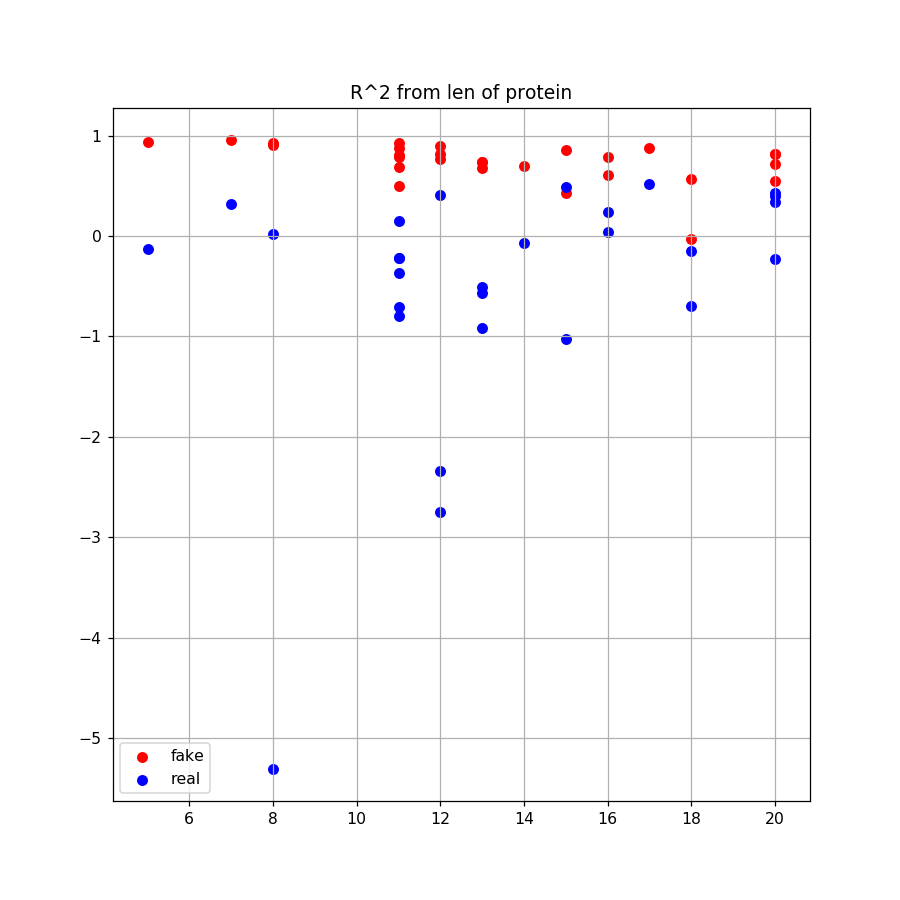

Fake 0.7373460228823172
Real -0.48650415938540076


In [364]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.set_title('R^2 from len of protein')
ax1.scatter(len_of_prot, fake_r2, c = 'r', label = 'fake')
ax1.scatter(len_of_prot, real_r2, c = 'b', label = 'real')
ax1.legend()
ax1.grid()
print('Fake', np.mean(fake_r2))
print('Real', np.mean( real_r2))

<IPython.core.display.Javascript object>


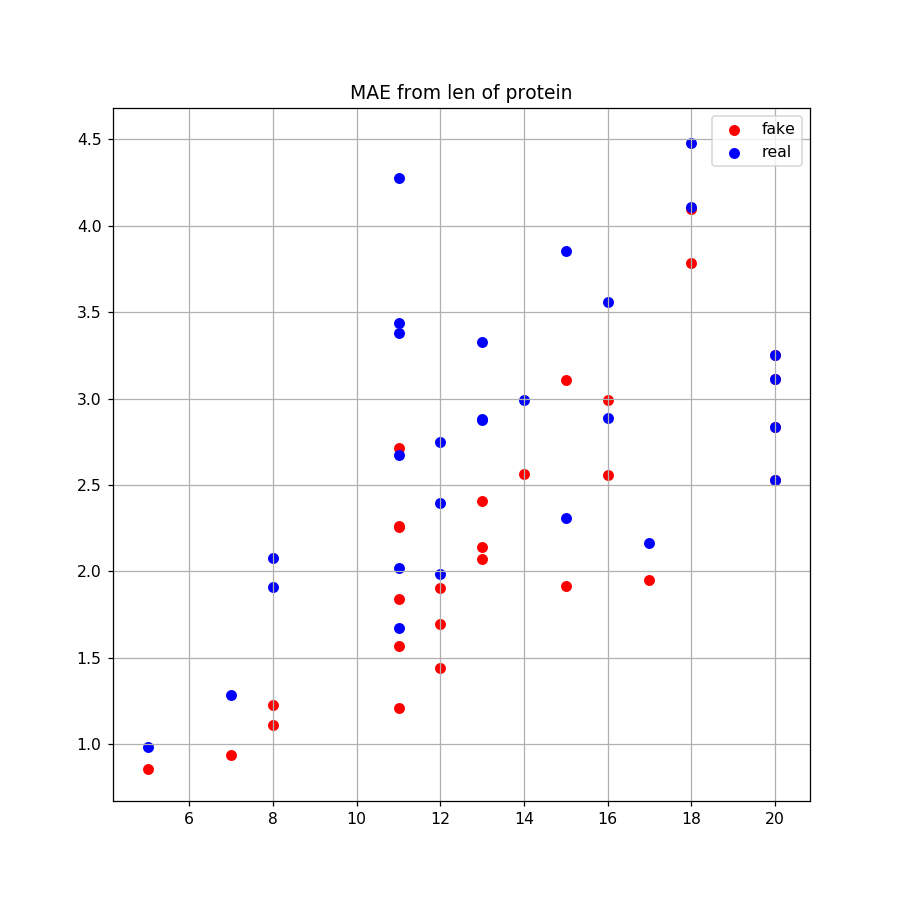

Fake 2.225840488217901
Real 2.786143388298285


In [365]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.set_title('MAE from len of protein')
ax1.scatter(len_of_prot, fake_mean, c = 'r', label ='fake')
ax1.scatter(len_of_prot, real_mean, c = 'b', label = 'real')
ax1.legend()
ax1.grid()
print('Fake', np.mean(fake_mean))
print('Real', np.mean(real_mean))

In [379]:
lab_gr.shape

(1890,)

<IPython.core.display.Javascript object>


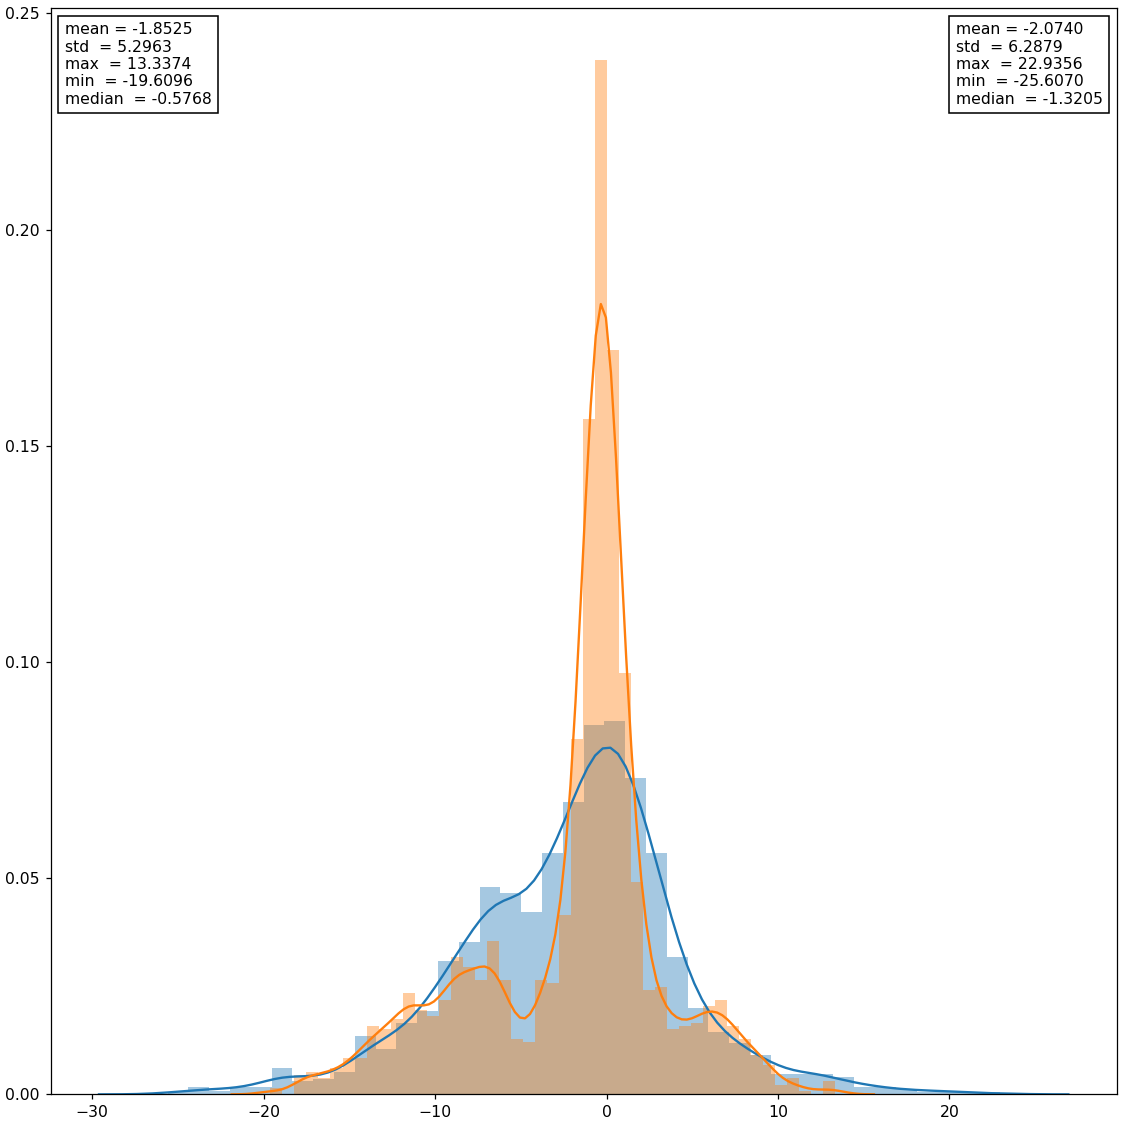

D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [366]:
lab_gr = np.array([x for sublist in real_test for x in sublist])
lab_gr1 = np.array([x for sublist in real_pred for x in sublist])
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
anchored_text = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (lab_gr.mean(), lab_gr.std(), lab_gr.max(), 
                                    lab_gr.min(), np.median(lab_gr)), loc='upper right')
anchored_text1 = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (lab_gr1.mean(), lab_gr1.std(), lab_gr1.max(), 
                                    lab_gr1.min(), np.median(lab_gr1)), loc='upper left')
ax.add_artist(anchored_text)
ax.add_artist(anchored_text1)
ax = sns.distplot(lab_gr)
ax = sns.distplot(lab_gr1)

In [99]:

for i in range(500):
    if TT[i][0] ==0:
        print(i)

50
51
52
53
54
55
56
57
58
59
60


IndexError: index 61 is out of bounds for axis 0 with size 61

In [439]:
ch.reshape(110, 5)

array([[-4.45186691e+01, -3.83786011e+01, -1.73085670e+01,
         1.42005720e+01,  2.78425002e+00],
       [-4.89626579e+01, -4.22937355e+01, -2.19188461e+01,
         1.13012819e+01,  6.53471649e-01],
       [-5.34784698e+01, -4.58629074e+01, -2.62906666e+01,
         7.62050009e+00,  2.69616580e+00],
       [-5.26771088e+01, -4.57132416e+01, -2.57408447e+01,
         4.48340368e+00, -1.57655048e+00],
       [-4.50361214e+01, -4.10923691e+01, -1.80827007e+01,
         2.05017686e+00, -2.91240239e+00],
       [-4.07412796e+01, -3.84484100e+01, -1.34408560e+01,
        -2.90599838e-02,  9.56085086e-01],
       [-3.39843979e+01, -3.33171005e+01, -6.64948797e+00,
        -8.18456650e-01,  1.56533927e-01],
       [-2.99039650e+01, -2.96272354e+01, -2.34758163e+00,
         1.43296325e+00,  2.98487878e+00],
       [-2.46855354e+01, -2.44117470e+01,  2.82047033e+00,
         1.94818163e+00,  1.30069578e+00],
       [-2.24457722e+01, -2.16432896e+01,  5.16664934e+00,
        -2.64829254e+00

In [441]:
ch_pred.reshape(110, 5)

array([[-3.4550987e+01, -2.4530338e+01, -8.3958759e+00,  1.7236481e+00,
         1.1679311e+00],
       [-3.2049473e+01, -2.3047470e+01, -7.5382829e+00,  1.0642976e+00,
         2.6864320e-01],
       [-3.0172068e+01, -2.1640892e+01, -7.4907312e+00,  4.8074952e-01,
        -5.7801110e-01],
       [-2.7859253e+01, -1.9672359e+01, -6.6243792e+00,  6.3938297e-02,
        -1.2098527e+00],
       [-2.5285252e+01, -1.8076738e+01, -6.1250515e+00, -4.3450841e-01,
        -1.8974289e+00],
       [-2.3891705e+01, -1.6527372e+01, -5.3961658e+00, -7.2279048e-01,
        -1.9620124e+00],
       [-2.2633488e+01, -1.4091822e+01, -4.5272985e+00, -9.7528499e-01,
        -1.6847377e+00],
       [-2.1612898e+01, -1.2331369e+01, -3.6486409e+00, -1.1370097e+00,
        -1.3370626e+00],
       [-2.0893774e+01, -1.0217464e+01, -3.2297957e+00, -1.1628014e+00,
        -7.5684202e-01],
       [-2.0316908e+01, -8.9746933e+00, -2.3451579e+00, -1.1263731e+00,
        -6.2369895e-01],
       [-1.9918680e+01, -7.044

In [442]:
np.mean(abs(TT-TT_pred))

7.624722457244044

In [443]:
np.mean(abs(ch-ch_pred))

8.26702782416998

In [444]:
from sklearn.metrics import r2_score
r2_score(valid_label[1], pred[1])

0.47679659416828146

In [445]:
r2_score(ch, ch_pred)

0.4758119203025989

In [807]:
np.mean(valid_label)

-1.9470529873243536

In [121]:
TT[3]

array([-13.37980843,  -8.41314602,   4.04737759,   8.85164738,
        -3.67495799])

In [113]:
valid_label[valid_label!=0].shape

(2066,)

In [114]:
target_lin[0]

129

In [54]:
6892000/5

1378400.0

In [55]:
ww = target.reshape(6892, 200, 5)

In [61]:
ww[ww==0].shape

(3543269,)

In [62]:
lab_gr = ww[ww!=0]

In [57]:
lab_gr.shape

(3348731,)

In [51]:
lab_gr

array([-20.74656296,  -2.31047702,  19.69578743, ..., -10.06443405,
       -13.22189999,  -2.85285783])

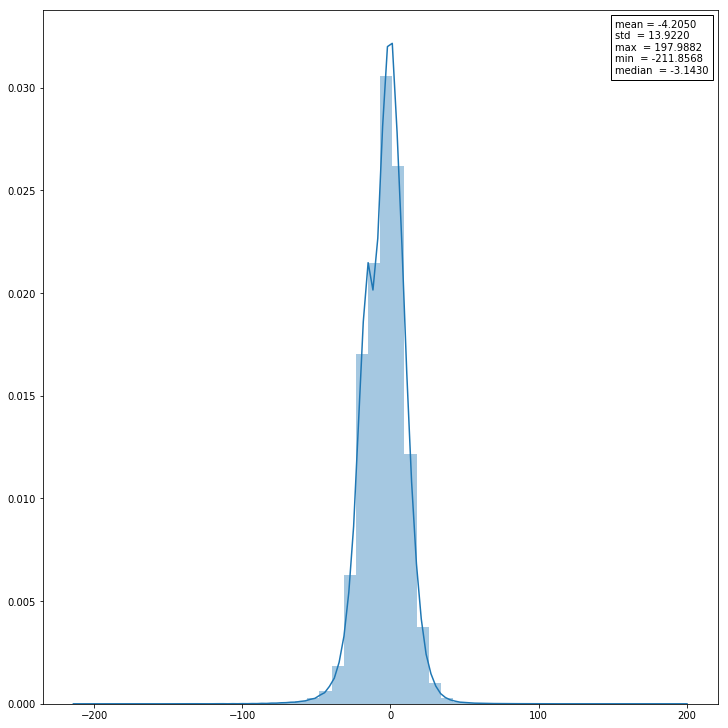

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
anchored_text = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (lab_gr.mean(), lab_gr.std(), lab_gr.max(), 
                                    lab_gr.min(), np.median(lab_gr)), loc='upper right')
ax.add_artist(anchored_text)
ax = sns.distplot(lab_gr)

In [ ]:
valid_label[0]

In [ ]:
pred[0]

In [402]:
n_hidden = 10
n_in = 5
n_out = 3
n_steps = 10
n_seq = 100
np.random.seed(0)
    # simple lag test
seq = np.random.randn(n_seq, n_steps, n_in)
targets = np.zeros((n_seq, n_steps, n_out))

In [404]:
seq.shape

(100, 10, 5)

In [405]:
targets.shape

(100, 10, 3)

Train on 28 samples, validate on 2 samples
Epoch 1/10
28/28 [==============================] - 2s 54ms/step - loss: 3.6546 - val_loss: 2.8044
Epoch 2/10
28/28 [==============================] - 0s 2ms/step - loss: 1.2518 - val_loss: 2.6717
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 1.1986 - val_loss: 2.5278
Epoch 4/10
28/28 [==============================] - 0s 2ms/step - loss: 1.1434 - val_loss: 2.3611
Epoch 5/10
28/28 [==============================] - 0s 2ms/step - loss: 1.0826 - val_loss: 2.1597
Epoch 6/10
28/28 [==============================] - 0s 2ms/step - loss: 1.0130 - val_loss: 1.9087
Epoch 7/10
28/28 [==============================] - 0s 2ms/step - loss: 0.9314 - val_loss: 1.5885
Epoch 8/10
28/28 [==============================] - 0s 2ms/step - loss: 0.8341 - val_loss: 1.1716
Epoch 9/10
28/28 [==============================] - 0s 2ms/step - loss: 0.7175 - val_loss: 0.6127
Epoch 10/10
28/28 [==============================] - 0s 2ms/step - loss: 0

<IPython.core.display.Javascript object>


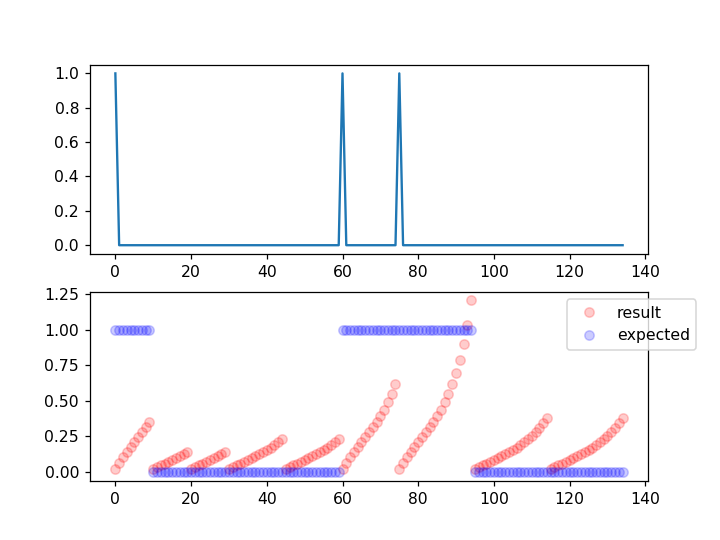

In [537]:
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.set_random_seed(1)

from keras import models
from keras.layers import Dense, Masking, LSTM

import matplotlib.pyplot as plt


def stateful_model():
    hidden_units = 256

    model = models.Sequential()
    model.add(LSTM(hidden_units, batch_input_shape=(1, 1, 1), return_sequences=False, stateful=True))
    model.add(Dense(1, activation='relu', name='output'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop')

    return model


def train_rnn(x_train, y_train, max_len, mask):
    epochs = 10
    batch_size = 200

    vec_dims = 1
    hidden_units = 256
    in_shape = (max_len, vec_dims)

    model = models.Sequential()

    model.add(Masking(mask, name="in_layer", input_shape=in_shape,))
    model.add(LSTM(hidden_units, return_sequences=False))
    model.add(Dense(1, activation='relu', name='output'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop')

    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_split=0.05)

    return model


def gen_train_sig_cls_pair(t_stops, num_examples, mask):
    x = []
    y = []
    max_t = int(np.max(t_stops))

    for t_stop in t_stops:
        one_indices = np.random.choice(a=num_examples, size=num_examples // 2, replace=False)

        sig = np.zeros((num_examples, max_t), dtype=np.int8)
        sig[one_indices, 0] = 1
        sig[:, t_stop:] = mask
        x.append(sig)

        cls = np.zeros(num_examples, dtype=np.bool)
        cls[one_indices] = 1
        y.append(cls)

    return np.concatenate(x, axis=0), np.concatenate(y, axis=0)


def gen_test_sig_cls_pair(t_stops, num_examples):
    x = []
    y = []

    for t_stop in t_stops:
        one_indices = np.random.choice(a=num_examples, size=num_examples // 2, replace=False)

        sig = np.zeros((num_examples, t_stop), dtype=np.bool)
        sig[one_indices, 0] = 1
        x.extend(list(sig))

        cls = np.zeros((num_examples, t_stop), dtype=np.bool)
        cls[one_indices] = 1
        y.extend(list(cls))

    return x, y


if __name__ == '__main__':
    noise_mag = 0.01
    mask_val = -10
    signal_lengths = (10, 15, 20)

    x_in, y_in = gen_train_sig_cls_pair(signal_lengths, 10, mask_val)

    mod = train_rnn(x_in[:, :, None], y_in, int(np.max(signal_lengths)), mask_val)

    testing_dat, expected = gen_test_sig_cls_pair(signal_lengths, 3)

    state_mod = stateful_model()
    state_mod.set_weights(mod.get_weights())

    res = []
    for s_i in range(len(testing_dat)):
        seq_in = list(testing_dat[s_i])
        seq_len = len(seq_in)

        for t_i in range(seq_len):
            res.extend(state_mod.predict(np.array([[[seq_in[t_i]]]])))

        state_mod.reset_states()

    fig, axes = plt.subplots(2)
    axes[0].plot(np.concatenate(testing_dat), label="input")

    axes[1].plot(res, "ro", label="result", alpha=0.2)
    axes[1].plot(np.concatenate(expected, axis=0), "bo", label="expected", alpha=0.2)
    axes[1].legend(bbox_to_anchor=(1.1, 1))

    plt.show()

In [ ]:
model.add(Conv2D(10, kernel_size=(50, 2),activation='linear',padding='same', W_regularizer=l2(l2_lambda), input_shape=(mm, 44, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))# уменьшаем размерность до 2 на 2
model.add(Dropout(0.5))
#2 слой
model.add(Conv2D(10, (50, 2), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.5))
#3 слой3
model.add(Conv2D(10, (50, 2), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.5))
#4 слой
model.add(Conv2D(20, (50, 2), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.5))
#5 слой
model.add(Conv2D(20, (50, 2), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.5))               
model.add(Flatten())
model.add(Dense(150, activation='linear', W_regularizer=l2(l2_lambda)))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.5))
model.add(Dense((5*(mm)), activation='linear'))

In [622]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from keras.utils import to_categorical
import numpy as np

model = Sequential()

model.add(Conv2D(10, kernel_size=(50, 2),activation='linear',padding='same',W_regularizer=l2(l2_lambda), input_shape=(None, 56, 1)))
model.add(TimeDistributed(Flatten()))
#model.add(TimeDistributed(Dense(2, activation='sigmoid')))
print(model.summary(90))

model.compile(loss='categorical_crossentropy',
              optimizer='adam')

def train_generator():
    s= 0 
    while True:
        #sequence_length = np.random.randint(10, 100)
        x_train = data1[s].reshape(-1, data1[s].shape[0], 56, 1)
        #y_train will depend on past 5 timesteps of x
        y_train = np.array(target[i])
        #print(x_train.shape)
        #print(y_train.shape)
        print(s)
        s+=1
        yield x_train, y_train

#for i in range(5):
#    train_generator()
model.fit_generator(train_generator(), steps_per_epoch=30, epochs=10, verbose=1)

D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, kernel_size=(50, 2), activation="linear", padding="same", input_shape=(None, 56,..., kernel_regularizer=<keras.reg...)`
  


__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
conv2d_57 (Conv2D)                      (None, None, 56, 10)                1010          
__________________________________________________________________________________________
time_distributed_61 (TimeDistributed)   (None, None, 560)                   0             
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
__________________________________________________________________________________________
None
Epoch 1/10
0
1
2
3
4
5
6
7
8
9
10
11


ValueError: Error when checking target: expected time_distributed_61 to have 3 dimensions, but got array with shape (129, 5)

In [ ]:
 x_train = data1[i][:44]
            y_train = np.array(target[i])
            z = data1[1].reshape(-1, data1[1].shape, 1)

In [ ]:
model.predict()

In [617]:
z = data1[1].reshape(-1, data1[1].shape[0], 56, 1)

In [618]:
z.shape

(1, 130, 56, 1)